## In this notebook, we will:

1.   Get familiar with some basic protein language model functionalities
2.   First finetuning and retrieval-augmented classification using Torch/Huggingface

## Prerequites:

1. Internet access
2. A computer with a GPU (the notebook scripts can run on a cpu instance, but training/inference will be significatively faster on a the google-colab T4 hosted runtime)

In [ ]:
!git clone https://github.com/EtienneGof/plm_intro.git

In [1]:
# Installing the python packages
!pip install datasets transformers[torch] sentencepiece faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 28.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl 

In [2]:
# Import the libraries

import os
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, AutoTokenizer, TrainingArguments, Trainer

# First interactions: tokenizer, generation, embeddings

In [3]:
device = 'cuda:0'
# device ='cpu' # If you don't have access to a gpu

ankh_base_path = "ElnaggarLab/ankh-base"

tokenizer = AutoTokenizer.from_pretrained(ankh_base_path)
model = T5ForConditionalGeneration.from_pretrained(ankh_base_path).to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.58k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

In [4]:
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(144, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(144, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(64, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=3072, bias=False)
              (wi_1): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Lin

## Tokenization

In [5]:

vocab = tokenizer.vocab
# Display the tokenizer vocabulary
print(f'Full vocabulary: {vocab}')

# Display the amino-acids tokens
aa_vocab = {k:v for k,v in vocab.items() if k[0]!='<'}
print(f'\nAmino acid vocabulary: {aa_vocab}')

# Display the protein sequence represented as tokens : https://www.uniprot.org/uniprotkb/P02819/entry#structure
protein = "YLYQWLGAPAPYPDPLEPKREVCELNPDCDELADHIGFQEAYRRFYGPV" # P02819 · OSTCN_MACFA
print(f"\nInitial protein: {protein}")
encoded_protein = tokenizer.encode_plus(protein)

# print the protein and corresponding encoding
print('\nEncoding of the protein:')
print(*[f'{aa} -> {token}' for aa, token in zip(protein, encoded_protein['input_ids'])], sep='\n')


Full vocabulary: {'<extra_id_18>': 125, '<extra_id_0>': 143, 'Q': 16, '<extra_id_104>': 39, '<extra_id_101>': 42, '<extra_id_97>': 46, '<extra_id_40>': 103, '<extra_id_103>': 40, '<extra_id_100>': 43, '<unk>': 2, '<extra_id_111>': 32, '<extra_id_35>': 108, 'N': 17, '<extra_id_22>': 121, '<extra_id_91>': 52, '<extra_id_62>': 81, '<extra_id_16>': 127, '<extra_id_60>': 83, '<extra_id_32>': 111, 'D': 10, '<extra_id_108>': 35, '<extra_id_99>': 44, '<extra_id_105>': 38, '<extra_id_28>': 115, '<extra_id_112>': 31, '<extra_id_96>': 47, '<extra_id_77>': 66, '<extra_id_53>': 90, '<extra_id_48>': 95, 'X': 23, '<extra_id_83>': 60, '<extra_id_56>': 87, '<extra_id_64>': 79, '<extra_id_12>': 131, '<extra_id_90>': 53, '<extra_id_52>': 91, '<extra_id_81>': 62, '<extra_id_73>': 70, '<extra_id_46>': 97, 'C': 22, '<extra_id_88>': 55, '<extra_id_24>': 119, '<extra_id_113>': 30, '<extra_id_8>': 135, '<extra_id_92>': 51, '<extra_id_41>': 102, '<extra_id_2>': 141, '<extra_id_82>': 61, '<extra_id_107>': 36, '<

### Protein generation

In [6]:
# Autoregressive generation
protein_prefix = protein[:-5]
protein_autoregressive_mask = protein_prefix + "<extra_id_0><extra_id_1><extra_id_2><extra_id_3><extra_id_4>"
print(f"Protein with causal mask: {protein_autoregressive_mask}")

encoded_prot = tokenizer.encode_plus(protein_autoregressive_mask, return_tensors='pt')
input_ids = encoded_prot['input_ids'].to(device)
generation = model.generate(input_ids=input_ids, temperature = 0.4, num_beams = 3, do_sample=True)

output_ids = generation[0].squeeze()
generated_amino_acids = list(tokenizer.decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False))
completed_protein = protein_prefix + "[" + "".join(generated_amino_acids) + "]"
print(f"Generation: {completed_protein}")

Protein with causal mask: YLYQWLGAPAPYPDPLEPKREVCELNPDCDELADHIGFQEAYRR<extra_id_0><extra_id_1><extra_id_2><extra_id_3><extra_id_4>


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generation: YLYQWLGAPAPYPDPLEPKREVCELNPDCDELADHIGFQEAYRR[LRAAA]


In [7]:
# 'In the middle' generation

def concatenate_subsequences(subsequences, fillings):
  masked_protein_sequence = ''
  for i in range(len(fillings)):
    masked_protein_sequence += subsequences[i] + fillings[i]
  masked_protein_sequence += subsequences[len(fillings)]

  return masked_protein_sequence


def apply_random_t5_mask(protein_sequence: str, n_mask:int):
  '''
  Replace randomly amino-acids with T5 mask id
  e.g.: 'ABCDEF' -> 'A<extra_id_0>CD<extra_id_1>ED'
  '''
  idx_to_replace = [0] + sorted(random.sample(range(0, len(protein_sequence)), n_mask)) + [len(protein_sequence)]
  subsequence_lengths = [idx_to_replace[i+1] - idx_to_replace[i] for i in range(len(idx_to_replace)-1)]

  subsequences = [protein_sequence[sum(subsequence_lengths[:i]):sum(subsequence_lengths[:i+1])] for i in range(n_mask+1)]
  masked_protein = concatenate_subsequences(subsequences, [f'<extra_id_{i}>' for i in range(n_mask)])

  return masked_protein, subsequences


masked_protein, subsequences = apply_random_t5_mask(protein, n_mask=3)
print(f"Protein with random replacement: {masked_protein}")

encoded_prot = tokenizer.encode_plus(masked_protein, return_tensors='pt')
input_ids = encoded_prot['input_ids'].to(device)
generation = model.generate(input_ids=input_ids, temperature = 0.4, num_beams = 3, do_sample=True)


output_ids = generation[0].squeeze()
generated_amino_acids = list(tokenizer.decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False))
completed_protein = concatenate_subsequences(subsequences, [f'[{aa}]' for aa in generated_amino_acids])
print(f"Generation: {completed_protein}")

Protein with random replacement: YLYQWLGAPAPYPDPLEPKR<extra_id_0>EVCELNPDCDELADHIGFQEAY<extra_id_1>RRFYGP<extra_id_2>V
Generation: YLYQWLGAPAPYPDPLEPKR[R]EVCELNPDCDELADHIGFQEAY[L]RRFYGP[G]V


## Retrieval-Augmented Classification with Frozen Embeddings

In [8]:
!git clone https://github.com/EtienneGof/plm_intro.git


Cloning into 'plm_intro'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 1), reused 15 (delta 1), pack-reused 0
Receiving objects: 100% (15/15), 6.81 MiB | 10.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [9]:
import json
import faiss

from torch.nn import functional as F
from multiprocessing import cpu_count
from tqdm.contrib.concurrent import process_map
from sklearn.metrics import roc_auc_score, average_precision_score
from transformers import EvalPrediction, EsmModel, EsmTokenizer
from operator import itemgetter
from torch import tensor, nn


In [10]:
# Load and preprocess the data

def get_data(model_name, device, batch_size=8):
    model = EsmModel.from_pretrained(model_name).to(device)
    tokenizer = EsmTokenizer.from_pretrained(model_name, do_lower_case=False)
    labels_embeddings = {split: get_embeddings(batch_size, device, model, tokenizer, split) for split in ['reference', 'train', 'val', 'test']}
    return labels_embeddings


def get_embeddings(batch_size, device, model, tokenizer, split, sample_size=100):
    dataset_path = os.path.join("plm_intro", "data", f"{split}.csv")
    dataframe = pd.read_csv(dataset_path).iloc[:sample_size,:]
    sequences = dataframe['Sequence'].astype(str).values.tolist()
    embeddings = []
    for idx in tqdm(range(0, len(sequences), batch_size), f"Computing embeddings of split {split} - {batch_size=}"):
        batch = sequences[idx: min(len(sequences), idx + batch_size)]
        batch_embeddings = get_batch_encoding(batch, device, tokenizer, model)
        embeddings += batch_embeddings

    labels = [eval(x) for x in dataframe['Labels'].values.tolist()]

    return {"labels": labels, "embeddings": embeddings}


def get_batch_encoding(batch, device, tokenizer, model):
    encoded = tokenizer.batch_encode_plus(batch,
                                          max_length=model.config.hidden_size,
                                          padding='max_length',
                                          return_token_type_ids=False,
                                          truncation=True)
    encoded = {key: torch.LongTensor(value).to(device) for key, value in encoded.items()}
    with torch.no_grad():
        outputs = model(**encoded)
    embedding = outputs[0].mean(dim=1).detach().cpu().tolist()
    return embedding


embedder_name = 'facebook/esm2_t6_8M_UR50D'
labels_embeddings = get_data(embedder_name, device)


config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Computing embeddings of split reference - batch_size=8: 100%|██████████| 13/13 [00:01<00:00, 11.91it/s]
Computing embeddings of split train - batch_size=8: 100%|██████████| 13/13 [00:00<00:00, 14.42it/s]
Computing embeddings of split val - batch_size=8: 100%|██████████| 13/13 [00:00<00:00, 17.66it/s]
Computing embeddings of split test - batch_size=8: 100%|██████████| 13/13 [00:01<00:00, 10.03it/s]


In [25]:
# Defines the dataset

class RagDataset(torch.utils.data.Dataset):
    def __init__(self, reference_embeddings, target_dataset, k, n_labels):

        self.reference_embeddings = np.ascontiguousarray(reference_embeddings, dtype=np.float32)
        self.target_embeddings = np.ascontiguousarray(target_dataset['embeddings'], dtype=np.float32)
        self.target_labels = target_dataset['labels']
        self.n_labels = n_labels
        self.k = int(k)

        # Build the index and store the train embeddings
        self.index = faiss.IndexFlatL2(self.reference_embeddings.shape[1])
        faiss.normalize_L2(self.reference_embeddings)
        self.index.add(self.reference_embeddings)

        # For all embeddings in the target_embeddings, retrieve the k nearest neighbors
        faiss.normalize_L2(self.target_embeddings)
        _, retrieved_faiss_indices = self.index.search(self.target_embeddings, k)
        self.retrieved_embeddings = itemgetter(*retrieved_faiss_indices)(self.reference_embeddings)

        # Aggregate the embeddings of the k nearest neighbors
        self.aggregated_retrieved_embeddings = [np.average(embeddings, axis=0) for embeddings in self.retrieved_embeddings]

    def __getitem__(self, idx):
        target_embedding = self.target_embeddings[idx]
        aggregated_embeddings = np.concatenate((self.aggregated_retrieved_embeddings[idx], target_embedding))

        label = self.target_labels[idx]
        encoded_labels = one_hot_encode([label], self.n_labels)
        input = {'embeddings': torch.tensor(aggregated_embeddings).unsqueeze(0),
                 'labels': torch.tensor(encoded_labels)}

        return input

    def __len__(self):
        return len(self.target_embeddings)


In [26]:
# Defines the model

class MultiLabelClassificationHead(nn.Module):
    def __init__(self, input_dim: int, num_labels: int):
        super().__init__()
        self.input_dim = input_dim
        self.num_labels = num_labels

        self.decoder_embeddings = nn.Sequential(
            nn.Linear(self.input_dim, 2**14),
            nn.ReLU(),
            nn.Linear(2**14, num_labels),
            nn.Sigmoid()
        )
        self.decoder_embeddings.apply(self.weights_init)
        self.sig = nn.Sigmoid()

    def weights_init(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.zeros_(m.bias)
            torch.nn.init.uniform_(m.weight)

    def _compute_loss(self, sigmoid_outputs, labels):
        return F.binary_cross_entropy(sigmoid_outputs, labels)


    def forward(self, embeddings, labels=None):
        outputs_embeddings = self.decoder_embeddings(embeddings)
        outputs = self.sig(outputs_embeddings)
        loss = self._compute_loss(outputs, labels)
        return loss, outputs


In [27]:
# Defines the classifier

class RAGClassifier:

    def __init__(self, hf_datasets: dict, k: int, n_labels: int):

        self.trainer = None
        assert k > 0, f"k must be greater than 0"
        self.k = int(k)
        self.predicted_logits = []
        self.reference_embeddings = hf_datasets['reference']['embeddings']
        self.train_dataset = hf_datasets['train']
        self.validation_dataset = hf_datasets['val']
        self.n_labels = n_labels
        self.seed = 0

    def compute_metrics(self, p: EvalPrediction):
        test_labels = tensor(p.label_ids[1]).squeeze(1)
        logits = tensor(p.predictions).squeeze(1)
        probs = nn.Softmax(dim=1)(logits)
        auc_auprcs = process_map(get_auc_auprc,
                                 [(probs[i], test_labels[i]) for i in range(len(test_labels))],
                                 chunksize=1,
                                 max_workers=10)
        auroc, auprc = np.mean([r[0] for r in auc_auprcs]), np.mean([r[1] for r in auc_auprcs])
        scores = {'auroc': auroc, 'auprc': auprc}

        return {label: np.round(score, 6) for label, score in scores.items()}

    def train_model(self, batch_size):

        train_dataset = RagDataset(self.reference_embeddings, self.train_dataset,self.k, self.n_labels)
        eval_dataset = RagDataset(self.reference_embeddings, self.validation_dataset, self.k, self.n_labels)
        torch.manual_seed(self.seed)

        model = MultiLabelClassificationHead(input_dim=len(self.reference_embeddings[0]) * 2, num_labels=self.n_labels) # 2 because the input embeddings are: target + average of retrieved embeddings
        train_args = TrainingArguments(
            'test_rag_classifier',
            evaluation_strategy="steps",
            logging_strategy="steps",
            logging_steps=50,
            eval_steps=250,
            save_strategy="no",
            learning_rate=2e-2,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=20,
            report_to=['none'],
            metric_for_best_model='eval_loss'
        )

        self.trainer = Trainer(
            model,
            train_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            compute_metrics=self.compute_metrics,
        )

        self.trainer.train()

    def predict(self, hf_test_dataset):
        test_dataset = RagDataset(self.reference_embeddings, hf_test_dataset, self.k, self.n_labels)
        self.predicted_logits = self.trainer.predict(test_dataset)
        scores = self.compute_metrics(self.predicted_logits)
        print(f'Test scores for K = {self.k}: {scores}')
        return scores


In [28]:
def one_hot_encode(input_list, n_labels):
    encodings = []
    for value in input_list:
        probability_vector = np.zeros(n_labels)
        probability_vector[value] = 1
        encodings.append(probability_vector.tolist())
    return encodings

def get_auc_auprc(args):
    scores, obs = args
    auroc = roc_auc_score(y_true=obs, y_score=scores)
    auprc = average_precision_score(y_true=obs, y_score=scores)
    return auroc, auprc


device = 'cuda:0'
batch_size = 16

with open(os.path.join("plm_intro", "data", "label_names.json"), 'r') as json_file:
    label_names = json.load(json_file)
n_labels = len(label_names)


In [29]:
all_test_scores = []
candidate_k = range(1,7)
for k in candidate_k:
    faissobj = RAGClassifier(labels_embeddings, k, n_labels)
    faissobj.train_model(batch_size)
    scores = faissobj.predict(labels_embeddings['test'])
    all_test_scores.append(scores)


Step,Training Loss,Validation Loss


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Test scores for K = 1: {'auroc': 0.744989, 'auprc': 0.325776}


Step,Training Loss,Validation Loss


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Test scores for K = 2: {'auroc': 0.606183, 'auprc': 0.261498}


Step,Training Loss,Validation Loss


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Test scores for K = 3: {'auroc': 0.60064, 'auprc': 0.274702}


Step,Training Loss,Validation Loss


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Test scores for K = 4: {'auroc': 0.575693, 'auprc': 0.269621}


Step,Training Loss,Validation Loss


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Test scores for K = 5: {'auroc': 0.563113, 'auprc': 0.26827}


Step,Training Loss,Validation Loss


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

Test scores for K = 6: {'auroc': 0.557676, 'auprc': 0.26061}


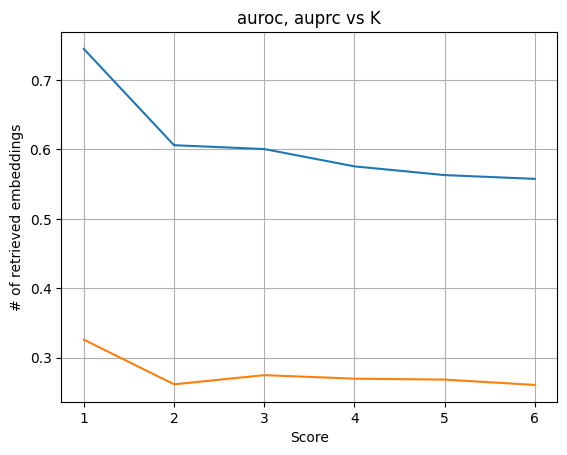

In [30]:
import matplotlib.pyplot as plt

def plot_scores(score_dicts: list[dict], candidate_k: list[int]):
    score_names = score_dicts[0].keys()
    # Plotting the lines
    for score in score_names:
        plt.plot(candidate_k, [x[score] for x in score_dicts], label=score)
    plt.title(f"{', '.join(score_names)} vs K")
    plt.xlabel('Score')
    plt.ylabel('# of retrieved embeddings')
    plt.grid(True)
    plt.show()

plot_scores(all_test_scores, list(candidate_k))

## Exercices:
- Replace L2 norm with cosine similarity
- Concatenate retrieved embeddings instead of averaging

## Fine-Tuning

In [17]:
import torch
from datasets import load_dataset, DatasetDict
from transformers import EsmTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

In [18]:
path_content = "./plm_intro/data"
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name)

In [19]:
datasets = DatasetDict({split:
                            load_dataset(path_content, data_files=[f"{split}.csv"], split='train')
                        for split in ['train', 'test', 'val']})

with open(os.path.join("plm_intro", "data", "label_names.json"), 'r') as json_file:
    label_names = json.load(json_file)

id2label = {idx:label for idx, label in enumerate(label_names)}
label2id = {label:idx for idx, label in enumerate(label_names)}

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
def preprocess_data(examples):
    text = examples["Sequence"]
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=320)
    labels_lists = one_hot_encode([np.array(eval(x)) for x in examples['Labels']], 677)
    encoding["labels"] = labels_lists
    return encoding

encoded_dataset = datasets.map(preprocess_data, batched=True, remove_columns=datasets['train'].column_names)

example = encoded_dataset['train'][0]
print(example.keys())
print(example['input_ids'])
print(tokenizer.decode(example['input_ids']))

encoded_dataset.set_format("torch")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'labels'])
[0, 20, 5, 6, 4, 6, 4, 6, 8, 5, 7, 14, 7, 22, 4, 5, 9, 13, 13, 4, 6, 23, 12, 12, 23, 16, 6, 4, 4, 13, 22, 14, 5, 11, 4, 14, 23, 6, 21, 8, 18, 23, 10, 21, 23, 4, 9, 5, 4, 22, 6, 5, 10, 13, 5, 10, 10, 22, 5, 23, 14, 11, 23, 10, 16, 6, 5, 5, 16, 16, 14, 21, 4, 10, 15, 17, 11, 4, 4, 16, 13, 4, 5, 13, 15, 19, 10, 10, 5, 5, 10, 9, 12, 16, 5, 6, 8, 13, 14, 5, 21, 23, 14, 23, 14, 6, 8, 8, 8, 4, 8, 8, 5, 5, 5, 10, 14, 10, 10, 10, 14, 9, 4, 16, 10, 7, 5, 7, 9, 10, 8, 12, 11, 9, 7, 5, 16, 9, 4, 11, 9, 4, 7, 9, 21, 4, 7, 13, 12, 7, 10, 8, 4, 16, 17, 16, 10, 14, 4, 8, 9, 8, 6, 16, 13, 17, 9, 4, 8, 12, 4, 6, 15, 5, 18, 8, 8, 6, 7, 13, 4, 8, 20, 5, 8, 10, 15, 4, 7, 11, 8, 13, 11, 5, 5, 6, 15, 12, 10, 13, 12, 4, 21, 13, 4, 9, 9, 12, 16, 9, 15, 4, 16, 9, 8, 7, 11, 22, 15, 9, 5, 14, 9, 5, 16, 20, 16, 6, 9, 4, 4, 9, 5, 14, 8, 8, 8, 8, 23, 14, 4, 14, 13, 16, 8, 21, 14, 5, 4, 10, 10, 5, 8, 10, 18, 5, 16, 22, 7, 12, 21, 14, 11, 18, 17, 4, 15, 8, 4, 8, 23,

In [21]:
def compute_metrics(p: EvalPrediction):
    test_labels = tensor(p.label_ids)
    logits = tensor(p.predictions).squeeze(1)
    probs = nn.Softmax(dim=1)(logits)
    auc_auprcs = process_map(get_auc_auprc,
                             [(probs[i], test_labels[i]) for i in range(len(test_labels))],
                             chunksize=1,
                             max_workers=10)
    auroc, auprc = np.mean([r[0] for r in auc_auprcs]), np.mean([r[1] for r in auc_auprcs])
    scores = {'auroc': auroc, 'auprc': auprc}

    return {label: np.round(score, 6) for label, score in scores.items()}


model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                            problem_type="multi_label_classification",
                                                            num_labels=len(label_names),
                                                            id2label=id2label,
                                                            label2id=label2id).to(device)

batch_size = 16
train_args = TrainingArguments(
    output_dir="./test_finetuning",
    evaluation_strategy="steps",
    logging_strategy="steps",
    logging_steps=30,
    eval_steps=30,
    save_strategy = "no",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    num_train_epochs=2,
    weight_decay=0.01,
    metric_for_best_model='eval_loss',
    report_to=["none"]
)

trainer = Trainer(
    model,
    train_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
predictions, labels, metrics_output = trainer.predict(encoded_dataset['test'])
print(metrics_output)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Auroc,Auprc
30,0.681300,0.670797,0.533685,0.082357
60,0.664400,0.660403,0.557846,0.084746


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

{'test_loss': 0.6602838635444641, 'test_auroc': 0.56062, 'test_auprc': 0.088509, 'test_runtime': 6.3474, 'test_samples_per_second': 78.772, 'test_steps_per_second': 5.041}


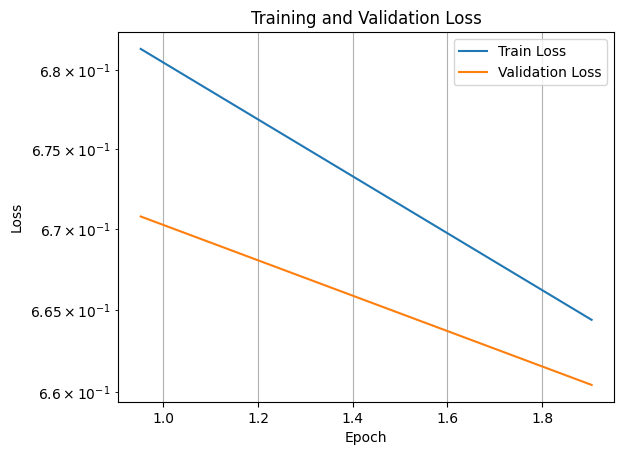

In [22]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_log):
    train_losses = []
    val_losses = []
    train_epochs = []
    val_epochs = []

    for entry in train_log:
        if 'loss' in entry:
            train_losses.append(entry['loss'])
            train_epochs.append(entry['epoch'])
        elif 'eval_loss' in entry:
            val_losses.append(entry['eval_loss'])
            val_epochs.append(entry['epoch'])

    plt.plot(train_epochs, train_losses, label='Train Loss')
    plt.plot(val_epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.show()


plot_loss_curve(trainer.state.log_history)

In [23]:
predictions, labels, metrics_output = trainer.predict(encoded_dataset['test'])

print(metrics_output)



  0%|          | 0/500 [00:00<?, ?it/s]

{'test_loss': 0.6602838635444641, 'test_auroc': 0.56062, 'test_auprc': 0.088509, 'test_runtime': 5.3319, 'test_samples_per_second': 93.775, 'test_steps_per_second': 6.002}
